In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

# Local application/library specific imports
from kan import *
import use_KAN
# from use_KAN import *

from use_training_set import *
import yaml

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


## Load data

In [2]:
W_list = [1,10,20,30,40]
filename_list = np.genfromtxt('./silica/20230804_desmearedData/FileNames.txt',dtype='str')

In [3]:
import os
n_des = 2
## load desmeared D22 data
data_path = './silica/20230804_desmearedData/'
data_list = []
data_list_6 = []
for i in range(5):
    filename = '{}_des{}.txt'.format(6+i,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list.append(data)

    filename = '{}_des{}.txt'.format(1+i,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list_6.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

In [4]:
def unpack_data(data):
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    return Q, IQ, IQ_er

## Plot data

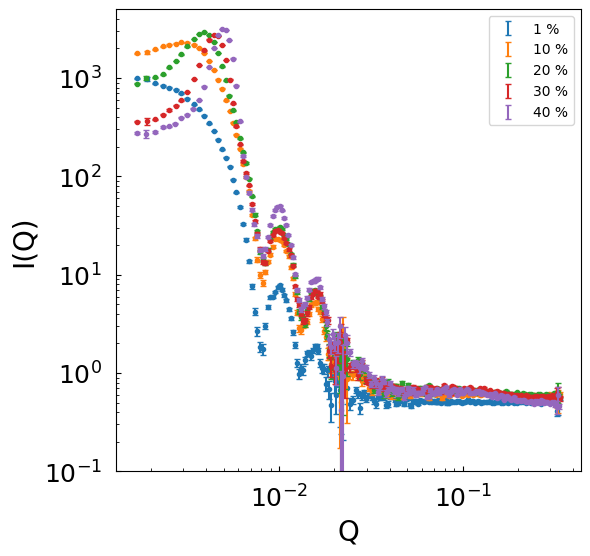

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = ['C0','C1','C2','C3','C4']
for i, W in enumerate(W_list):
    dataname = '{} %'.format(W)
    data = data_list[i]
    Q, IQ, IQ_er = unpack_data(data)
    ax.plot(Q,IQ,'.', color = colors[i])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i] ,capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_ylim([0.1,5000])
ax.set_xlabel('Q',fontsize=20)
ax.set_ylabel('I(Q)',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()
plt.show()

## Define function

In [6]:
## fit desmeared D22 dilute data for form factor

# fit P(Q)
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def fuzzysphere(q,sigma=1,sigma_f=0.1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2*np.exp(-(sigma_f*sigma*q)**2/2)
    return P

def log_normal_pdf(mu,sigma,x):
    return np.exp(-(np.log(x)-mu)**2/2/sigma**2)/x/sigma

def P_HS_eff(q,sigma=1,d_sigma=0.05):
    n_sample = 101
    sigma_list = (1+np.linspace(-5,5,n_sample)*d_sigma)*sigma
    # p_sigma = np.exp(np.linspace(-3,3,n_sample)**2/2)*(sigma_list)**6
    p_sigma = log_normal_pdf(0,d_sigma,sigma_list/sigma)*(sigma_list)**6
    # var = d_sigma**2
    # k = 1/var
    # x = (1+np.linspace(-3,3,n_sample)*d_sigma)
    # p_sigma = k**k*x**(k-1)*np.exp(-k*x)/gamma(k)

    P_eff = np.zeros_like(q)

    for i in range(n_sample):
        P_i = hardsphere(q,sigma_list[i])*p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff/np.sum(p_sigma)

    return P_eff

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out # sampled on Q

def I_P(Q, dQ, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    Q_fine = Q
    P_res = IQ_resoln(Q,Q_fine,P,dQ)
    f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    P = f_interp(Q)

    return A*P + I_inc    

def I_P_d(Q, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    # Q_fine = Q
    # P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    # f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    # P = f_interp(Q)

    return A*P + I_inc    

## Fit form factor

In [7]:
# 1%
data = data_list[0]
Q, IQ, IQ_er = unpack_data(data)
IQ_P = IQ
IQ_er_P = IQ_er

# remove extreme values
index_extreme = IQ<0.4
Q = np.delete(Q,index_extreme)
IQ = np.delete(IQ,index_extreme)
IQ_er = np.delete(IQ_er,index_extreme)

# initialize parameters
params = Parameters()
params.add('sigma', value=1500, min=1100, max=1300)
params.add('A', value=1e3, min=5e2, max=1.5e3)
params.add('I_inc', value=0.8, min=0.5, max=1)
params.add('d_sigma', value=0.08, min=0.005, max=0.15)

index_Q = (Q>1e-3)*(Q<5e-1)
# loss function for fitting form factor
def lambda_P(params, Q, IQ_exp, index_Q):
    v = params.valuesdict()
    return (((I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])) 
           - (IQ_exp))/IQ_er**2)[index_Q]

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_P, params, fcn_args=(Q, IQ, index_Q))
result_P = minner.minimize(method='nedler')

# fitted curve
v = result_P.params.valuesdict()
IQ_fit = I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])

# write error report
report_fit(result_P)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 491
    # data points      = 192
    # variables        = 4
    chi-square         = 1984706.72
    reduced chi-square = 10556.9507
    Akaike info crit   = 1782.74938
    Bayesian info crit = 1795.77936
[[Variables]]
    sigma:    1135.97764 +/- 39.0976034 (3.44%) (init = 1300)
    A:        962.651040 +/- 221.111635 (22.97%) (init = 1000)
    I_inc:    0.50763014 +/- 6.6268e-04 (0.13%) (init = 0.8)
    d_sigma:  0.06739722 +/- 0.03070081 (45.55%) (init = 0.08)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, d_sigma) = -0.5226
    C(sigma, A)       = +0.4452


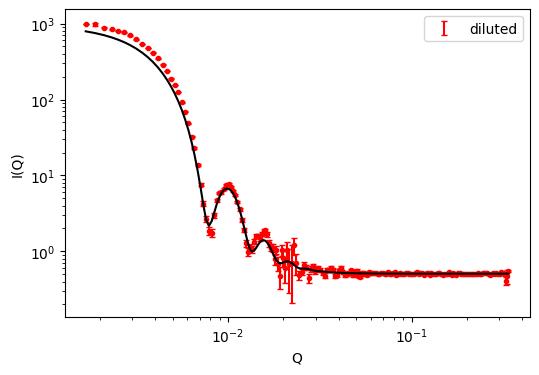

In [8]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.r')
ax.errorbar(Q,IQ,IQ_er,linestyle='',label='diluted',color='r',capsize=2)
# ax.plot(Q_p,IQ_data_p,'.m',label='diluted')
ax.plot(Q[index_Q],IQ_fit,'-k',zorder=3)
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 178
    # variables        = 2
    chi-square         = 2537200.63
    reduced chi-square = 14415.9127
    Akaike info crit   = 1706.53233
    Bayesian info crit = 1712.89590
[[Variables]]
    A:      6861.87429 +/- 1377.45132 (20.07%) (init = 10000)
    I_inc:  0.61199114 +/- 0.00188635 (0.31%) (init = 0.5)


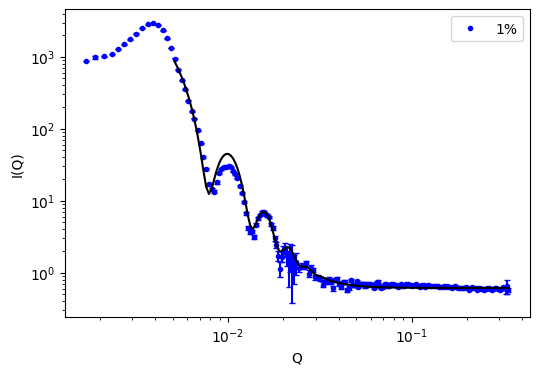

In [9]:
# 20%
data = data_list[2]
Q, IQ, IQ_er = unpack_data(data)
IQ_I = IQ
IQ_er_I = IQ_er

# # remove extreme values
# index_extreme = (Q>0.022) & (Q<0.023)
# Q = np.delete(Q,index_extreme)
# IQ = np.delete(IQ,index_extreme)
# IQ_er = np.delete(IQ_er,index_extreme)

# loss function for fitting form factor
def lambda_I(params, Q, IQ_exp, index_Q):
    v = params.valuesdict()
    return (((I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)) 
           - (IQ_exp))/IQ_er**2)[index_Q]

sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=1e4, min=2e2, max=2e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q>5e-3)*(Q<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q, IQ, index_Q))
result_I = minner.minimize()

# fitted curve
v = result_I.params.valuesdict()
IQ_fit = I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)

# write error report
report_fit(result_I)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.b',label='{}%'.format(1))
ax.errorbar(Q,IQ,IQ_er,linestyle='',color='b',capsize=2)
ax.plot(Q[index_Q],IQ_fit[index_Q],'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

In [10]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

## Fit structure factor

### load KAN model

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
cpu = torch.device('cpu')
device = cpu
torch.set_default_dtype(torch.float32)

In [12]:
device

device(type='cpu')

In [13]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)


In [14]:
with open('setup_model_9_7.txt', 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)

Device set to: cpu
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [15]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_9_7_sin_full_ft.pth'))

<All keys matched successfully>

In [16]:
def f_SQ_KAN(model, x, Q=Q, device=device):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

lf_SQ_KAN = lambda x, Q: f_SQ_KAN(model_KAN, x, Q, device=device)

def err_L2(x,y):
    index_loss = np.random.randint(95, size=76)
    return np.mean((x[index_loss]-y[index_loss])**2)

In [17]:
# initialize parameters
params = Parameters()
params.add('C', value=6380.22932 , min=1e2, max=5e4, vary=True)
params.add('I_inc', value=0.8618089, min=0.4, max=2, vary=True)
params.add('sigma', value=0.97286556, min=0.9, max=1.1, vary=True)
params.add('d_sigma', value=0.07121961, min=0.005, max=0.1, vary=False)

fp_i =       [0.151, 0.2,  5]
fp_ubounds = (0.155,  0.25,   20)
fp_lbounds = (0.15, 0.05,  5)
fp_name = ['phi', 'kappa', 'A']
for i in range(3):
    params.add(fp_name[i], value=fp_i[i], min=fp_ubounds[i], max=fp_lbounds[i])

def IQ_th(params, Q):
    v = params.valuesdict()
    fp = np.array([v['phi'],v['kappa'],np.log(v['A']),1])
    x = np.array([fp[0:3]])
    x_torch = use_KAN.to_torch_device(x, device=device)
    
    # structure factor
    S = lf_SQ_KAN(x_torch,Q).cpu().detach().numpy()
    S = savgol_filter(S[0],7,2)

    # form factor
    P = P_HS_eff(Q,sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*P*S + v['I_inc']

    return I

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (x-y)/z
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])

# do fit, here with the Nedler algorithm
index_Q = (Q*fp_opt_P["sigma"]>1.5)*(Q*fp_opt_P["sigma"]<16)
minner = Minimizer(lmbda, params, fcn_args=(Q*fp_opt_P['sigma'],IQ,IQ_er,index_Q))
result = minner.minimize(method='nelder')

# write error report
report_fit(result)


/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 552
    # data points      = 47
    # variables        = 6
    chi-square         = 8430.04020
    reduced chi-square = 205.610737
    Akaike info crit   = 255.902233
    Bayesian info crit = 267.003119
##  Warning: uncertainties could not be estimated:
    I_inc:    at boundary
    phi:      at boundary
[[Variables]]
    C:        7064.18002 (init = 6380.229)
    I_inc:    0.40000009 (init = 0.8618089)
    sigma:    0.99400311 (init = 0.9728656)
    d_sigma:  0.07121961 (fixed)
    phi:      0.15000001 (init = 0.151)
    kappa:    0.22072983 (init = 0.2)
    A:        5.57367770 (init = 5)


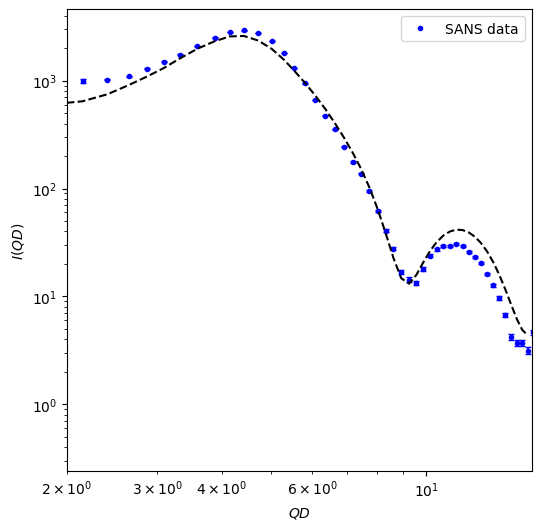

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Q*fp_opt_P['sigma'],IQ_I,'.b',label='SANS data')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I,IQ_er_I,linestyle='',color='b',capsize=2)
ax.plot(Q[index_Q]*fp_opt_P['sigma'], IQ_th(params,Q*fp_opt_P['sigma'])[index_Q],'--k')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([2,16])
# ax.set_ylim([2,3000])
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

In [19]:
## evaluate uncertainty
def cov_fp(v, IQ_rs, IQ_er_rs, index_Q):
    delta = 0.05
    x_list = 1 + np.linspace(-5,5,7)*delta
    phi_list = x_list*v['phi']
    kappa_list = x_list*v['kappa']
    A_list = x_list*v['A']
    fp_center = [v['phi'],v['kappa'],np.log(v['A'])]
    phi_grid, kappa_grid, A_grid = np.meshgrid(phi_list, kappa_list, A_list)
    phi_flat = phi_grid.flatten(order='C')
    kappa_flat = kappa_grid.flatten(order='C')
    A_flat = A_grid.flatten(order='C')
    fp_flat_list = [phi_flat,kappa_flat,np.log(A_flat)]

    def IQ_fp(fp):
        x = np.array([fp[0:3]])
        x_torch = use_KAN.to_torch_device(x, device=device)
        
        # structure factor
        S = lf_SQ_KAN(x_torch,Q*fp_opt_P['sigma']).cpu().detach().numpy()
        S = savgol_filter(S[0],7,2)

        # form factor
        P = P_HS_eff(Q*fp_opt_P['sigma'],sigma=v['sigma'], d_sigma=v['d_sigma'])

        I = v['C']*P*S + v['I_inc']
        return I

    # calculate likelihood
    likelihood_flat = np.zeros_like(phi_flat)
    for i in np.arange(len(phi_flat)):
        index = np.unravel_index(i, phi_grid.shape)
        fp = [phi_flat[i], kappa_flat[i], np.log(A_flat[i])]
        IQ = IQ_fp(fp)
        minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/z)**2))
        likelihood_flat[i] = minimizer_target(IQ[index_Q],IQ_rs[index_Q],IQ_er_rs[index_Q])

    # calculate covariance matrix
    cov = np.zeros([3,3])
    for m in range(3):
        for n in range(3):
            d_m = fp_flat_list[m]-fp_center[m]
            d_n = fp_flat_list[n]-fp_center[n]
            cov[m,n] = np.sum(likelihood_flat*d_m*d_n)/np.sum(likelihood_flat)

    return cov

def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)   
def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

epsilon_0 = 8.854e-12 # Vacuum_permittivity (F*m^-1 = Columb^2 J^-1 m^-1)
epsilon_water = 80.4*epsilon_0 #  Water permittivity @ 20 degree C
epsilon_glycerol = 47*epsilon_0 #  Glycerol permittivity @ 20 degree C
e = 1.60217663e-19 # Electron charge (Columb)
kB = 1.380649e-23 # Boltzmann constant (J/K)
sigma = fp_opt_P['sigma']*1e-10 # Particle diameter (m)
Z_0 = np.sqrt((kB*293*sigma)*epsilon_glycerol/e**2)

In [20]:
v = result.params.valuesdict()
cov = cov_fp(v, IQ, IQ_er, index_Q)
fp = [v['phi'],v['kappa'],np.log(v['A'])]
fp_std = np.sqrt(np.diag(cov))
fp_Z = Z(np.exp(fp[2]),fp[1])*Z_0
fp_std_Z = Z_err(np.exp(fp[2]),fp[1],fp_std[2],fp_std[1])*Z_0
print('phi   = {:0.4f} +- {:0.4f}'.format(fp[0],fp_std[0]))
print('kappa = {:0.4f} +- {:0.4f}'.format(fp[1],fp_std[1]))
print('lnA     = {:0.4f} +- {:0.4f}'.format(fp[2],fp_std[2]))
print('Z     = {:0.4f} +- {:0.4f}'.format(fp_Z,fp_std_Z))

phi   = 0.1500 +- 0.0000
kappa = 0.2207 +- 0.0374
lnA     = 1.7181 +- 0.0959
Z     = 21.0403 +- 2.4782


In [21]:
## save_fitting results
IQ_fit_P = I_P_d(Q, fp_opt_P['sigma'], fp_opt_P['A'], fp_opt_P['I_inc'], fp_opt_P['d_sigma'])

filename = 'results_20.mat'
mdic = {'Q':Q, 'IQ_I':IQ_I, 'IQ_er_I':IQ_er_I, 'IQ_fit':IQ_th(params,Q*fp_opt_P['sigma']),
        'IQ_P':IQ_P, 'IQ_er_P':IQ_er_P, 'IQ_fit_P':IQ_fit_P,
        'sigma':sigma, 'fp':fp, 'fp_std':fp_std, 'fp_Z':fp_Z, 'fp_std_Z':fp_std_Z, 'v':v}
savemat(filename,mdic)